## Natural Gas ARIMA Model

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

### Data Preprocessing

In [2]:
df = pd.read_csv('pricedata.csv')

In [3]:
df.head()

,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,1/4/2000,23.90,24.70,23.89,24.39,32509,USD
1,Brent Oil,1/5/2000,24.25,24.37,23.70,23.73,30310,USD
2,Brent Oil,1/6/2000,23.55,24.22,23.35,23.62,44662,USD
3,Brent Oil,1/7/2000,23.57,23.98,23.05,23.09,34826,USD
4,Brent Oil,1/10/2000,23.04,23.78,23.04,23.73,26388,USD


In [4]:
# There are four different kinds of oil in this dataset, but I only care about Natural Gas
df = df[df['Symbol'] == 'Natural Gas'].reset_index(drop = True)

In [5]:
df['Date'] = [dt.datetime.strptime(date_str, '%m/%d/%Y').date() for date_str in df['Date']]

In [6]:
df.set_index(df['Date'], inplace = True)

In [7]:
df.drop(columns = 'Date', inplace = True)

We can use either the opening or closing price of the stock (there is no significant difference). Our team arbitrarily chose to train our models on the daily closing price of the stock.

### Check for Stationarity

In [8]:
close = df['Close']

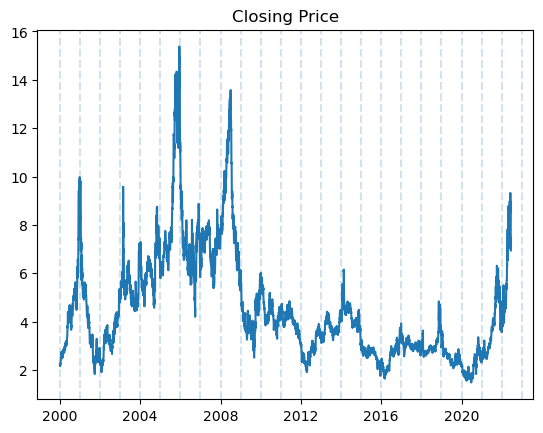

In [9]:
plt.plot(close)
plt.title('Closing Price')
for year in range(2000, 2024):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), linestyle = '--', alpha = 0.2)

plt.show()

In order to train an ARIMA model, our data must be stationary. We must satisfy 3 requirements to consider our data to be stationary:

1. Constant mean: Our data does not satisfy this; it looks like the mean before 2009 is about 6 while the mean after 2009 is about 4
2. Constant variance: Our data seems to satisfy this requirement, aside from a very random events (sudden spikes or drops in the data)
3. No seasonality: This one seems to be satistfied. Although the price exhibits oscillatory behavior between 2011 and 2020, it does not seem to be related to the time of year

We can also perform the Augmented Dickey-Fuller test, which mathematically determines if a dataset is stationary.

In [10]:
ad_fuller_test = adfuller(close)
print(f"ADF Statistic: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF Statistic: -3.3866556093439413
p-value: 0.011422280329119273


As you can see from the ADF test above, we do have some statistical evidence that our data is stationary, but we'd like this to be even stronger (the p-value is less than 0.05 but greater than 0.01).

In conclusion, our data is not currently stationary. We will try to fix this by taking the first difference and checking this for stationarity.

In [11]:
first_diff = close.diff().dropna()
first_diff

Date
2000-01-05   -0.008
2000-01-06    0.028
2000-01-07   -0.023
2000-01-10    0.043
2000-01-11    0.044
              ...  
2022-06-13   -0.241
2022-06-14   -1.420
2022-06-15    0.231
2022-06-16    0.044
2022-06-17   -0.520
Name: Close, Length: 5741, dtype: float64

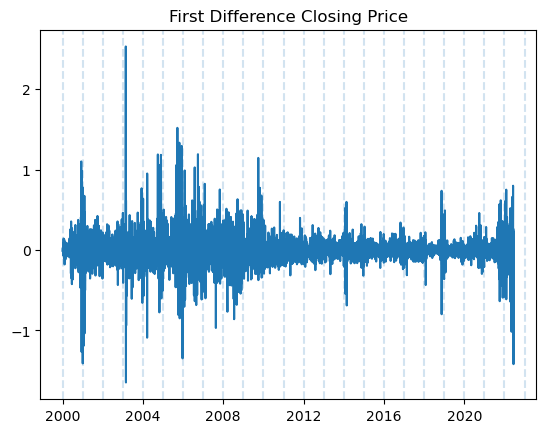

In [12]:
plt.plot(first_diff)
plt.title('First Difference Closing Price')
for year in range(2000, 2024):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), linestyle = '--', alpha = 0.2)

plt.show()

In [13]:
ad_fuller_test = adfuller(first_diff)
print(f"ADF Statistic: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF Statistic: -15.915731704281034
p-value: 8.028641405838648e-29


As you can see from the above graph, our data now seems to have a constant mean. We may question whether it has a constant variance (it seems to be greater before 2010 than after 2010), but in general there is no signficant change. Finally, we don't see any seasonality in our data. These visual perceptions are confirmed by the ADF test, which yielded a p-value very close to 0.

We are now ready to determine the parameters for our ARIMA model.

### Determining Parameters of ARIMA Model

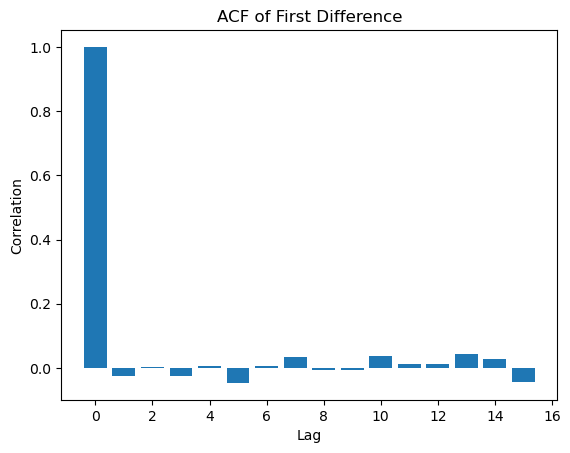

In [14]:
ACF = acf(first_diff)
plt.bar(range(16), ACF[:16])
plt.title("ACF of First Difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

There seem to be significant lags at 1, 3, and 5, with 5 being the strongest. Thus, we will first try an ARIMA model with MA(5).

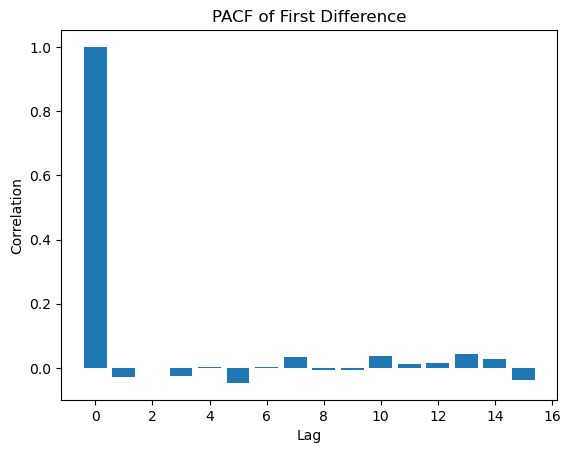

In [15]:
PACF = pacf(first_diff)
plt.bar(range(16), PACF[:16])
plt.title("PACF of First Difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

Similarly, we see strong lags for the PACF at 1, 3, and 5. So we will first try an ARIMA model with AR(5).

### Training the ARIMA Model

We will train our model up to the end of 2021 and try to predict the oil price for the first 6 months of 2022

In [16]:
first_diff.index = range(len(first_diff.index))

In [17]:
train = first_diff[:-122] # Cutoff for start of 2022
test = first_diff[-122:]

In [18]:
model = ARIMA(train, order = (3, 0, 3))
model_fit = model.fit()

C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5619
Model:                 ARIMA(3, 0, 3)   Log Likelihood                1642.115
Date:                Sun, 05 May 2024   AIC                          -3268.229
Time:                        16:22:38   BIC                          -3215.158
Sample:                             0   HQIC                         -3249.738
                               - 5619                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.174      0.862      -0.004       0.005
ar.L1          0.0186      0.033      0.566      0.572      -0.046       0.083
ar.L2         -0.0922      0.031     -2.956      0.0

In [20]:
pred = model_fit.predict(start = len(train), end = len(train) + len(test) - 1)
pred = pd.DataFrame(pred).reset_index(drop = True)

In [21]:
test = test.reset_index()

In [22]:
result = pd.concat([test, pred], axis = 1)

In [23]:
result.set_index('index', inplace = True)

In [24]:
result

,Close,predicted_mean
index,,
5619,0.085,-0.014197
5620,-0.098,0.018479
5621,0.165,-0.007494
5622,-0.070,0.012208
5623,0.104,-0.015391
...,...,...
5736,-0.241,-0.001350
5737,-1.420,0.001722
5738,0.231,0.003452


<Axes: xlabel='index'>

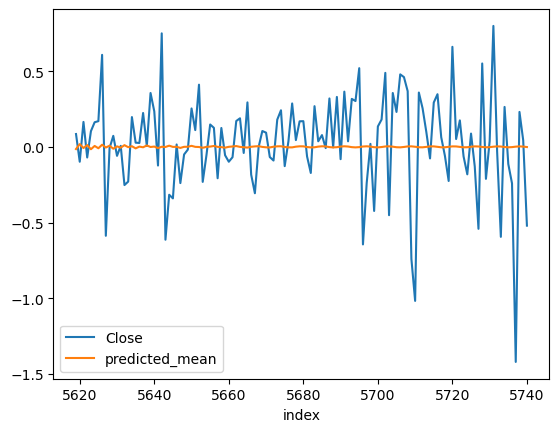

In [25]:
result.plot()

In [26]:
df

,Symbol,Open,High,Low,Close,Volume,Currency
Date,,,,,,,
2000-01-04,Natural Gas,2.130,2.200,2.130,2.176,30152,USD
2000-01-05,Natural Gas,2.180,2.200,2.125,2.168,27946,USD
2000-01-06,Natural Gas,2.165,2.220,2.135,2.196,29071,USD
2000-01-07,Natural Gas,2.195,2.230,2.155,2.173,28455,USD
2000-01-10,Natural Gas,2.180,2.255,2.165,2.216,28916,USD
...,...,...,...,...,...,...,...
2022-06-13,Natural Gas,8.920,8.950,8.382,8.609,167556,USD
2022-06-14,Natural Gas,8.686,8.889,7.008,7.189,273717,USD
2022-06-15,Natural Gas,7.269,7.698,7.201,7.420,123589,USD


## Testing ARIMA Model on Parts of Dataset

Let's try running an ARIMA model on our dataset for the years 2011-2020

In [28]:
gas = df.loc[dt.datetime(year = 2011, month = 1, day = 1).date():dt.datetime(year = 2020, month = 1, day = 1).date()]

In [30]:
gas.head()

,Symbol,Open,High,Low,Close,Volume,Currency
Date,,,,,,,
2011-01-03,Natural Gas,4.492,4.689,4.491,4.650,156619,USD
2011-01-04,Natural Gas,4.627,4.707,4.557,4.669,160213,USD
2011-01-05,Natural Gas,4.611,4.640,4.447,4.473,116906,USD
2011-01-06,Natural Gas,4.486,4.623,4.380,4.434,164028,USD
2011-01-07,Natural Gas,4.400,4.450,4.327,4.422,124905,USD


<Axes: xlabel='Date'>

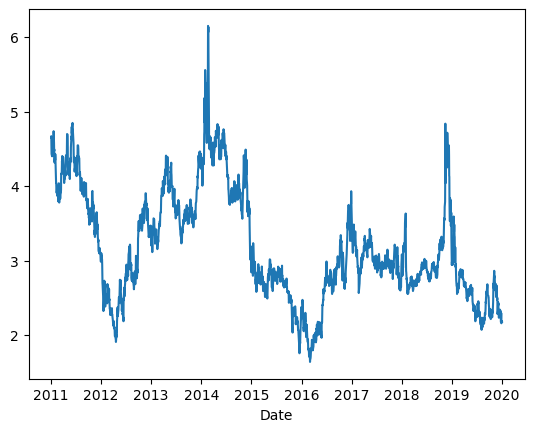

In [32]:
gas['Close'].plot()

In [50]:
close = gas['Close']
ad_fuller_test = adfuller(close)
print(f"ADF Statistic: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF Statistic: -3.0119920441770547
p-value: 0.033789569718083945


In [55]:
first_diff = close.diff().dropna()
first_diff

1       0.019
2      -0.196
3      -0.039
4      -0.012
5      -0.023
        ...  
2334    0.058
2335   -0.136
2336    0.028
2337    0.003
2338   -0.010
Name: Close, Length: 2338, dtype: float64

In [56]:
ad_fuller_test = adfuller(first_diff)
print(f"ADF Statistic: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF Statistic: -51.584021626678556
p-value: 0.0


<Axes: >

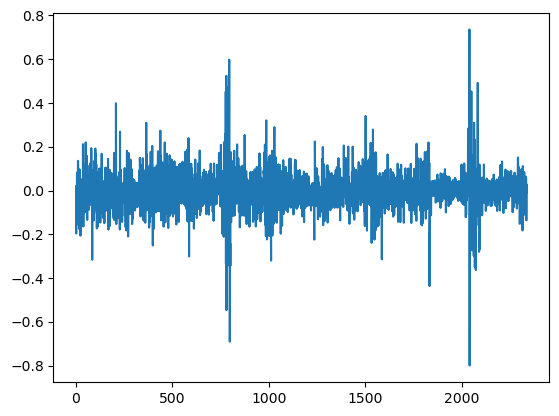

In [58]:
first_diff.plot()

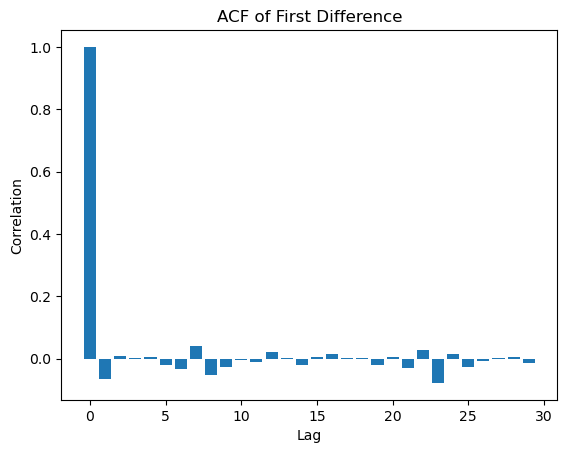

In [60]:
ACF = acf(first_diff)
plt.bar(range(30), ACF[:30])
plt.title("ACF of First Difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

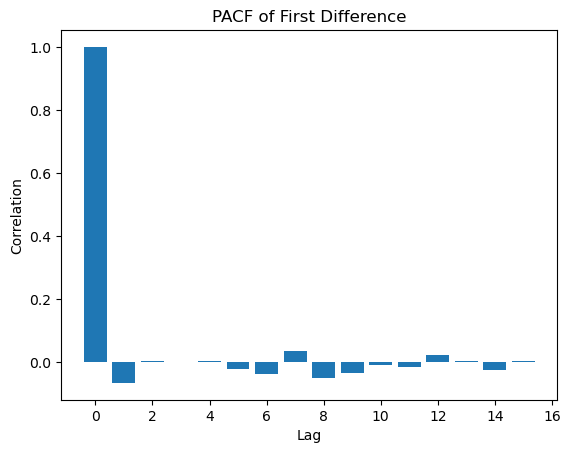

In [61]:
PACF = pacf(first_diff)
plt.bar(range(16), PACF[:16])
plt.title("PACF of First Difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

In [62]:
train = first_diff[:-100]
test = first_diff[-100:]

In [63]:
model = ARIMA(train, order = (1, 0, 1))
model_fit = model.fit()

C:\Users\david\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\david\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\david\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [67]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2238
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2150.116
Date:                Sun, 05 May 2024   AIC                          -4292.232
Time:                        16:40:24   BIC                          -4269.379
Sample:                             0   HQIC                         -4283.888
                               - 2238                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.580      0.562      -0.005       0.003
ar.L1         -0.1312      0.165     -0.793      0.428      -0.455       0.193
ma.L1          0.0631      0.165      0.384      0.7

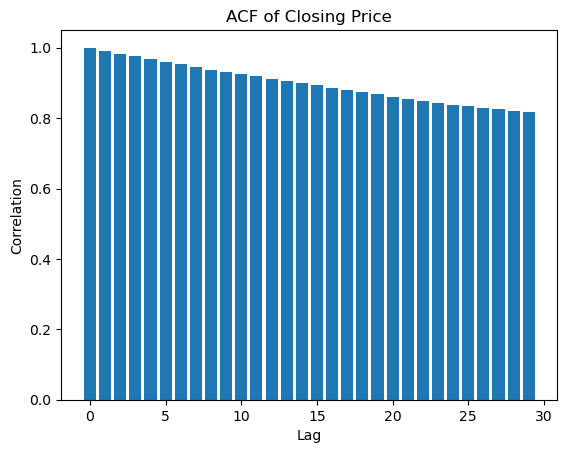

In [51]:
ACF = acf(close)
plt.bar(range(30), ACF[:30])
plt.title("ACF of Closing Price")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

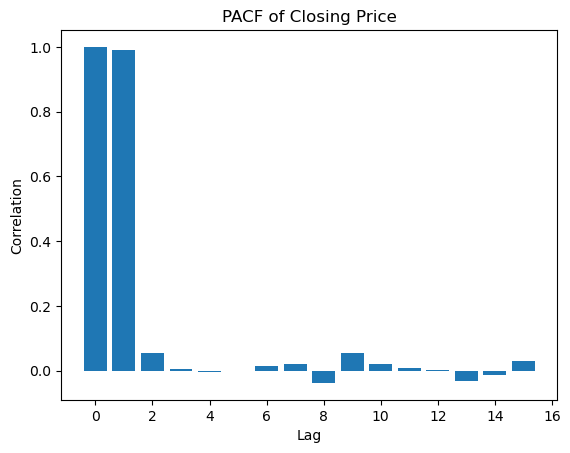

In [52]:
PACF = pacf(close)
plt.bar(range(16), PACF[:16])
plt.title("PACF of Closing Price")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

In [44]:
close.index = range(len(close))

In [46]:
len(close)

2339

In [47]:
train = close[:-100]
test = close[-100:]

In [48]:
model = ARIMA(train, order = (2, 0, 5))
model_fit = model.fit()

C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2239
Model:                 ARIMA(2, 0, 5)   Log Likelihood                2152.210
Date:                Sun, 05 May 2024   AIC                          -4286.420
Time:                        16:33:36   BIC                          -4234.996
Sample:                             0   HQIC                         -4267.646
                               - 2239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2979      0.256     12.886      0.000       2.796       3.800
ar.L1          0.8080      0.798      1.012      0.311      -0.757       2.373
ar.L2          0.1837      0.792      0.232      0.8

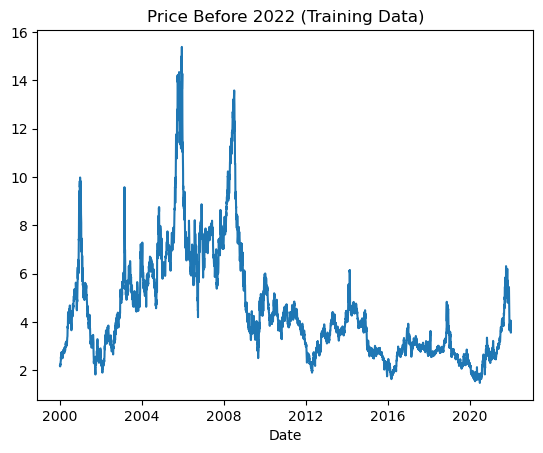

In [71]:
df.loc[:dt.datetime(year = 2022, month = 1, day = 1).date()]['Close'].plot()
plt.title('Price Before 2022 (Training Data)')
plt.show()

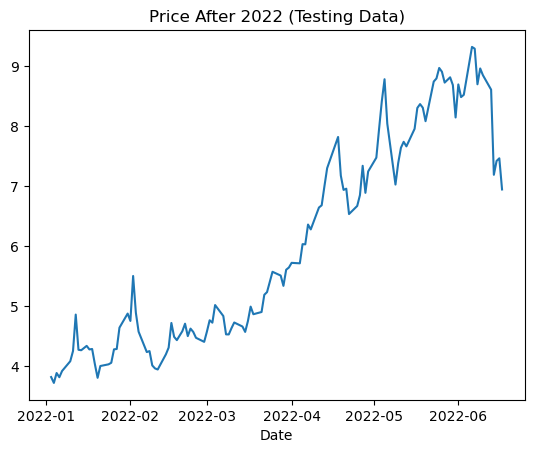

In [72]:
df.loc[dt.datetime(year = 2022, month = 1, day = 1).date():]['Close'].plot()
plt.title('Price After 2022 (Testing Data)')
plt.show()

## Rolling Forecast Origin

In [31]:
first_diff[:test['Date'][3]]

Date
2000-01-05   -0.008
2000-01-06    0.028
2000-01-07   -0.023
2000-01-10    0.043
2000-01-11    0.044
              ...  
2021-12-31    0.169
2022-01-03    0.085
2022-01-04   -0.098
2022-01-05    0.165
2022-01-06   -0.070
Name: Close, Length: 5623, dtype: float64

In [39]:
first_diff

0      -0.008
1       0.028
2      -0.023
3       0.043
4       0.044
        ...  
5736   -0.241
5737   -1.420
5738    0.231
5739    0.044
5740   -0.520
Name: Close, Length: 5741, dtype: float64

In [40]:
predictions = pd.Series(dtype = 'float64')

for day in range(len(train) + 1, len(first_diff)):
    train_data = first_diff[:day - 1]
    model = ARIMA(train_data, order = (5, 0, 5))
    model_fit = model.fit()
    pred = model_fit.predict(day)
    print(pred)
    predictions.loc[day] = pred.loc[day]

C:\Users\david\AppData\Local\Temp\ipykernel_31448\2656936466.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5620    0.009394
dtype: float64


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5621    0.021127
dtype: float64



KeyboardInterrupt

